In [1]:
seed = 42
import pandas as pd
import numpy as np
import random
np.random.seed(seed)
random.seed(seed)

Load the data

In [2]:
data = pd.read_csv('data/EEG_data.csv')
data.columns

"""
load subtitle vectors  
"""
sub_vec_path = 'data/subtitles/subtitle_vecs.npy'
sub_vecs = np.load(sub_vec_path)
sub_vec_dim = sub_vecs.shape[1]

"""
Make a dataset of original data combined with sub vecs 
"""
dataset = np.hstack((data.values.astype('float32'), sub_vecs))


Define target variable and training variables

In [3]:
# The student's confusion column is 14, predefined label is 13
y_col = 13
orig_train_data_cols = list(range(2,y_col))
vector_cols = list(np.arange(sub_vec_dim) + 15) 

train_cols = orig_train_data_cols
n_dims = len(train_cols)

PCA to reduce dimension of the word average vectors (might give better results) to reduce training speed

In [4]:
from sklearn.decomposition import PCA

#sub_vec_dim = 100
#pca = PCA(n_components=sub_vec_dim)
#pcad_sub_vecs = pca.fit_transform(sub_vecs)
#dataset = np.hstack((data.values.astype('float32'), pcad_sub_vecs))

'\nPCA to reduce dimension of the word average vectors (might give better results)\n'

Functions to make interval counts even for all data points

In [5]:
def min_max_rows_per_subject_vid(X):
    VideoID = list(set(X[:,1]))
    SubjectID = list(set(X[:,0]))

    max_intervals = 0 # length of signal
    min_intervals = len(X)

    for subId in SubjectID:
        for vidId in VideoID:
            X_tmp=X[(X[:, 0] == subId) & (X[:, 1] == vidId)]
            max_intervals = max(len(X_tmp), max_intervals)
            min_intervals = min(len(X_tmp), min_intervals)
    print(max_intervals)
    print(min_intervals)
    assert max_intervals == 144
    return min_intervals, max_intervals

min_intervals, max_intervals = min_max_rows_per_subject_vid(dataset)



def zero_pad_data(data, max_intervals, train_cols, y_col):
    X_pad = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0])) 
    for subId in SubjectID:
        for vidId in VideoID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]

            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            
            pad_len = max_intervals - X_sv.shape[0]
    
            z = np.zeros((pad_len, X_sv.shape[1]), dtype=X_sv.dtype)
            z[:,0] = X_sv[:,0][pad_len]
            z[:,1] = X_sv[:,1][pad_len]
            
            X_sv_pad = np.concatenate((X_sv, z), axis=0)
            X_sv_pad = X_sv_pad.reshape(1, -1)

            X_pad = X_sv_pad if X_pad is None else np.vstack((X_pad, X_sv_pad))
            
    return X_pad, np.array(y)

def truncate_data(data, min_intervals, train_cols, y_col):
    X_trunc = None
    y = []
    VideoID = list(set(data[:,1]))
    SubjectID = list(set(data[:,0]))
    for vidId in VideoID:
        for subId in SubjectID:
            data_sv = data[(data[:,0]==subId) & (data[:,1]==vidId)]
 
            y.append(data_sv[:, y_col].mean())

            X_sv = data_sv[:, train_cols]
            trunc_len = min_intervals
            X_sv_trunc = X_sv[0:trunc_len].reshape(1, -1)
            X_trunc = X_sv_trunc if X_trunc is None else np.vstack((X_trunc, X_sv_trunc))
    return X_trunc, np.array(y)

144
112


In [6]:
"""
Cross-validate
"""
from time import time
from sklearn.metrics import precision_recall_fscore_support as pr_f1, accuracy_score as accur, matthews_corrcoef, \
roc_auc_score
from sklearn.base import clone, BaseEstimator
from time import time
import numpy as np

def get_scores(modelname, y, y_hat):
    acc = accur(y, y_hat)
    matt = matthews_corrcoef(y, y_hat)
    p, r, f1, sup = pr_f1(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)
    return acc, f1[1], f1[0], roc_auc

def sklearn_cross_validate(modelname, model, data, intervals, even_data, n_test=2):
    """
    even_data: either truncate_data or zero_pad_data to make number of intervals
             even for each data point
    """
    results = []
    start = time()
    for i in range(0, 10, n_test):
        cv_model = clone(model)
        
        
        X_train, y_train = even_data(data[np.in1d(data[:,0], (i, i+1), invert=True)],
                                     intervals, train_cols, y_col)
        X_test, y_test = even_data(data[np.in1d(data[:,0], (i, i+1))],
                                   intervals, train_cols, y_col)
        
        print(X_train.shape)
        #print(y_test)
        cv_model.fit(X_train, y_train)
        
        print('{}-fold cross validation for model {}, iteration {}'
              .format(int(10/n_test), modelname, len(results) +1))
        acc, f1, f1_flip, roc_auc = get_scores('svm', y_test, np.round(cv_model.predict(X_test)))

        results.append({'acc': acc, 'F1': f1, 'F1-flipped': f1_flip, 'roc-auc': roc_auc})
        result_means = {key:np.mean([r[key] for r in results]) for key in results[0].keys()}
        print('current cross-validation mean accuracy: {:.3f}, f1: {:.3f}, f1 flipped: {:.3f} and roc-auc: {:.3f}'.format(
              *result_means.values()))
    print('cross-validation total time: {:.3f} seconds'.format(time() - start))
    return result_means, results


Test cross-validation with Support Vector Classifier

In [13]:
print(dataset.shape)
from sklearn.svm import SVC
model = SVC(C=1, kernel='linear')
result_means, results = sklearn_cross_validate('svc', model, dataset, max_intervals, zero_pad_data)

(12811, 1039)
(80, 1584)
5-fold cross validation for model svc, iteration 1
current cross-validation mean accuracy: 0.650, f1: 0.667, f1 flipped: 0.632 and roc-auc: 0.650
(80, 1584)
5-fold cross validation for model svc, iteration 2
current cross-validation mean accuracy: 0.625, f1: 0.679, f1 flipped: 0.530 and roc-auc: 0.625
(80, 1584)
5-fold cross validation for model svc, iteration 3
current cross-validation mean accuracy: 0.617, f1: 0.638, f1 flipped: 0.566 and roc-auc: 0.617
(80, 1584)
5-fold cross validation for model svc, iteration 4
current cross-validation mean accuracy: 0.613, f1: 0.618, f1 flipped: 0.583 and roc-auc: 0.612
(80, 1584)
5-fold cross validation for model svc, iteration 5
current cross-validation mean accuracy: 0.640, f1: 0.654, f1 flipped: 0.600 and roc-auc: 0.640
cross-validation total time: 0.464 seconds


Helper functions to save models in a format that can be used to create a pandas DataFrame

In [8]:
def init_scores():
    return {'Model':[], 'Accuracy':[], 'F1':[], 'F1 flipped':[], 'ROC-AUC':[]}

def save_model_score(scores, name, results):
    scores['Model'].append(name)
    scores['Accuracy'].append(results['acc'])
    scores['F1'].append(results['F1'])
    scores['F1 flipped'].append(results['F1-flipped'])
    scores['ROC-AUC'].append(results['roc-auc'])

In [9]:
class Naive(BaseEstimator):
    def __init__(self):
        self.X = None
        self.y = None
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X):
        return np.zeros(len(X))

Perform cross-validation on multiple models 

In [10]:
import warnings

def warn(*args, **kwargs):
    pass

old_warn = warnings.warn
warnings.warn = warn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP

scores = init_scores()

seed = np.random.randint(0, 2000)
models = {'Naive': Naive(),
          'Logreg': lm.LogisticRegression(random_state=seed),
          'Ptron': lm.Perceptron(random_state=seed),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'GNB': GaussianNB(),
          'BNB': BernoulliNB(),
          'RF': RandomForestClassifier(random_state=seed),
          'GBT': GradientBoostingClassifier(n_estimators=777,
                                            random_state=seed),
          'MLP2': MLP(hidden_layer_sizes=((32,)*2), random_state=seed,
                       solver='adam', activation='logistic'),
          'MLP3': MLP(hidden_layer_sizes=((16, 8, 16)), random_state=seed,
                       solver='adam', activation='logistic'),
          'SVC Linear': SVC(C=1, kernel='linear', random_state=seed)}

for name, model in models.items():
    result_means, results = sklearn_cross_validate(name, model, dataset, min_intervals, truncate_data)
    save_model_score(scores, name, result_means)
    

(80, 1232)
5-fold cross validation for model Naive, iteration 1
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model Naive, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model Naive, iteration 3
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model Naive, iteration 4
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model Naive, iteration 5
current cross-validation mean accuracy: 0.500, f1: 0.000, f1 flipped: 0.667 and roc-auc: 0.500
cross-validation total time: 0.405 seconds
(80, 1232)
5-fold cross validation for model Logreg, iteration 1
current cross-validation mean accuracy: 0.550, f1: 0.571, f1 flipped: 0.526 and roc-auc: 0.550
(80, 1232)
5-fold cross validation for model Logreg, iteration 2
current cross-validation mean accuracy: 0.575, f1: 0.586, f1 flipped: 0.563 and roc-auc: 0.575
(80, 1232)
5-fold cross validation for model Logreg, iteration 3
current cross-validation mean accuracy: 0.567, f1: 0.547, f1 flipped: 0.578 and roc-auc: 0.567
(80, 1232)
5-fold cross validation for model Logreg, iteration 4
current cross-validation mean accuracy: 0.562, f1: 0.553, f1 flipped: 0.565 and roc-auc: 0.562

/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model KNN, iteration 2
current cross-validation mean accuracy: 0.400, f1: 0.528, f1 flipped: 0.118 and roc-auc: 0.400
(80, 1232)
5-fold cross validation for model KNN, iteration 3
current cross-validation mean accuracy: 0.467, f1: 0.552, f1 flipped: 0.278 and roc-auc: 0.467
(80, 1232)
5-fold cross validation for model KNN, iteration 4
current cross-validation mean accuracy: 0.475, f1: 0.568, f1 flipped: 0.280 and roc-auc: 0.475
(80, 1232)
5-fold cross validation for model KNN, iteration 5
current cross-validation mean accuracy: 0.490, f1: 0.576, f1 flipped: 0.318 and roc-auc: 0.490
cross-validation total time: 0.471 seconds
(80, 1232)
5-fold cross validation for model GNB, iteration 1
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model GNB, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.655, f1 flipped: 0.083 and roc-auc: 0.500


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model GNB, iteration 3
current cross-validation mean accuracy: 0.500, f1: 0.659, f1 flipped: 0.056 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model GNB, iteration 4
current cross-validation mean accuracy: 0.475, f1: 0.557, f1 flipped: 0.167 and roc-auc: 0.475
(80, 1232)
5-fold cross validation for model GNB, iteration 5
current cross-validation mean accuracy: 0.500, f1: 0.573, f1 flipped: 0.244 and roc-auc: 0.500
cross-validation total time: 0.397 seconds
(80, 1232)
5-fold cross validation for model BNB, iteration 1
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model BNB, iteration 2
current cross-validation mean accuracy: 0.550, f1: 0.667, f1 flipped: 0.250 and roc-auc: 0.550
(80, 1232)
5-fold cross validation for model BNB, iteration 3
current cross-validation mean accuracy: 0.533, f1: 0.667, f1 flipped: 0.167 and roc-auc: 0.533


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model BNB, iteration 4
current cross-validation mean accuracy: 0.525, f1: 0.625, f1 flipped: 0.250 and roc-auc: 0.525
(80, 1232)
5-fold cross validation for model BNB, iteration 5
current cross-validation mean accuracy: 0.520, f1: 0.633, f1 flipped: 0.200 and roc-auc: 0.520
cross-validation total time: 0.410 seconds
(80, 1232)
5-fold cross validation for model RF, iteration 1
current cross-validation mean accuracy: 0.650, f1: 0.632, f1 flipped: 0.667 and roc-auc: 0.650


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model RF, iteration 2
current cross-validation mean accuracy: 0.625, f1: 0.594, f1 flipped: 0.652 and roc-auc: 0.625
(80, 1232)
5-fold cross validation for model RF, iteration 3
current cross-validation mean accuracy: 0.617, f1: 0.596, f1 flipped: 0.634 and roc-auc: 0.617
(80, 1232)
5-fold cross validation for model RF, iteration 4
current cross-validation mean accuracy: 0.588, f1: 0.558, f1 flipped: 0.612 and roc-auc: 0.587
(80, 1232)
5-fold cross validation for model RF, iteration 5
current cross-validation mean accuracy: 0.580, f1: 0.526, f1 flipped: 0.618 and roc-auc: 0.580
cross-validation total time: 0.455 seconds
(80, 1232)
5-fold cross validation for model GBT, iteration 1
current cross-validation mean accuracy: 0.750, f1: 0.737, f1 flipped: 0.762 and roc-auc: 0.750
(80, 1232)
5-fold cross validation for model GBT, iteration 2
current cross-validation mean accuracy: 0.625, f1: 0.618, f1 flipped: 0.631 and roc-auc: 0.625
(80, 1232)
5-fold c

/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


5-fold cross validation for model MLP3, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model MLP3, iteration 3
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model MLP3, iteration 4
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(80, 1232)
5-fold cross validation for model MLP3, iteration 5
current cross-validation mean accuracy: 0.500, f1: 0.667, f1 flipped: 0.000 and roc-auc: 0.500
cross-validation total time: 1.008 seconds
(80, 1232)


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


5-fold cross validation for model SVC Linear, iteration 1
current cross-validation mean accuracy: 0.500, f1: 0.583, f1 flipped: 0.375 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model SVC Linear, iteration 2
current cross-validation mean accuracy: 0.500, f1: 0.613, f1 flipped: 0.271 and roc-auc: 0.500
(80, 1232)
5-fold cross validation for model SVC Linear, iteration 3
current cross-validation mean accuracy: 0.517, f1: 0.542, f1 flipped: 0.394 and roc-auc: 0.517
(80, 1232)
5-fold cross validation for model SVC Linear, iteration 4
current cross-validation mean accuracy: 0.512, f1: 0.532, f1 flipped: 0.420 and roc-auc: 0.512
(80, 1232)
5-fold cross validation for model SVC Linear, iteration 5
current cross-validation mean accuracy: 0.550, f1: 0.571, f1 flipped: 0.470 and roc-auc: 0.550
cross-validation total time: 0.485 seconds


Plot the results

         Model  Accuracy        F1  F1 flipped  ROC-AUC
0        Naive      0.50  0.000000    0.666667     0.50
1       Logreg      0.61  0.606325    0.607821     0.61
2        Ptron      0.54  0.444444    0.560606     0.54
3          KNN      0.49  0.575911    0.318319     0.49
4          GNB      0.50  0.572511    0.244444     0.50
5          BNB      0.52  0.633333    0.200000     0.52
6           RF      0.58  0.526316    0.617697     0.58
7          GBT      0.53  0.545489    0.504825     0.53
8         MLP2      0.45  0.409273    0.448496     0.45
9         MLP3      0.50  0.666667    0.000000     0.50
10  SVC Linear      0.55  0.570693    0.469667     0.55
['Naive' 'Logreg' 'Ptron' 'KNN' 'GNB' 'BNB' 'RF' 'GBT' 'MLP2' 'MLP3'
 'SVC Linear']


<IPython.core.display.Javascript object>


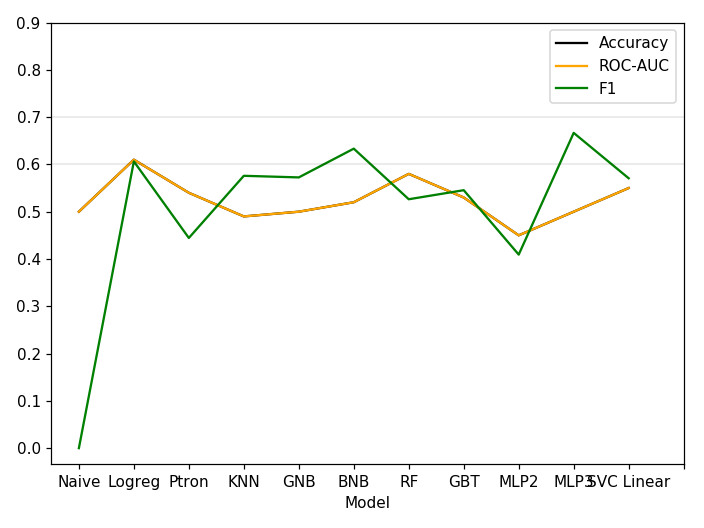

In [11]:
%matplotlib notebook
from matplotlib import pyplot as plt

scores_df = pd.DataFrame(data=scores)
print(scores_df)
print(scores_df.Model.values)


ax = scores_df.plot(kind='line', x='Model', y=['Accuracy', 'ROC-AUC', 'F1'], xticks=range(len(models) + 1),
                    yticks=np.arange(10) / 10, color=['black', 'orange', 'green'])
ax.set_xticklabels(list(scores_df.Model))
for p in ax.patches:
     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
ax.axhline(y=0.7, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
ax.axhline(y=0.6, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
plt.tight_layout()
plt.show()